In [1]:
import torchvision.datasets as datasets
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
from pylatex import Document, Section, Subsection, Tabular, Math, TikZ, Axis, \
    Plot, Figure, Matrix, Alignat


C:\ProgramData\Miniconda3\envs\ml37\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [7]:
from sklearn.decomposition import PCA
import numpy as np


def prep_mnist(mnist_set, n_components):
    # should we normalize the data?
    filtered_mnist_set = []
    for image in mnist_set:
        if image[1] == 0 or image[1] == 1:
            filtered_mnist_set.append(image)

    X = [np.asarray(val[0]).flatten() for val in filtered_mnist_set]
    Y = [val[1] for val in filtered_mnist_set]

    pca = PCA(n_components=n_components)
    X_PC = pca.fit_transform(X)
    return (X_PC, Y)

def confusion_matrix(Y, Y_hat):
    # Y is the ground truth
    # Y_hat is the predicted labels
    # returns the confusion matrix
    cm = np.zeros((2, 2))
    for i in range(len(Y)):
        cm[Y[i], Y_hat[i]] += 1
    return cm

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [290]:
class KNNClassifier:
    def __init__(self, X, Y):
        self.X_clf = np.array(X)
        self.Y_clf = np.array(Y)

    def classify(self, x, k, dist_func=np.linalg.norm, decision_weighted=False):
        # Implement the k-NN classifier
        # x is a single vector to classify
        # k is the number of neighbors to consider
        # returns the most common class among the k nearest neighbors
        if self.X_clf is None or self.Y_clf is None:
            raise Exception("Classifier not trained")

        # Vectorized implementation for speed
        distances = dist_func(self.X_clf - x, axis=1)
        sorted_indices = np.argsort(distances)
        k_nearest_indices = sorted_indices[:k]
        k_nearest_labels = self.Y_clf[k_nearest_indices]
        # count the number of 0s and 1s
        count0 = 0
        count1 = 0
        if decision_weighted:
            for i in range(len(k_nearest_indices)):
                if k_nearest_labels[i] == 0:
                    count0 += 1 / distances[k_nearest_indices[i]]
                else:
                    count1 += 1 / distances[k_nearest_indices[i]]
        else:
            for i in range(len(k_nearest_indices)):
                if k_nearest_labels[i] == 0:
                    count0 += 1
                else:
                    count1 += 1
        # return the most common class
        if count0 > count1:
            return 0
        else:
            return 1

    def plot_decision_boundary(self, k, dist_func=np.linalg.norm, decision_weighted=False, h=50):
        x_min, x_max = self.X_clf[:, 0].min() - 1, self.X_clf[:, 0].max() + 1
        y_min, y_max = self.X_clf[:, 1].min() - 1, self.X_clf[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = np.zeros(xx.shape)
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                Z[i, j] = self.classify(np.array([xx[i, j], yy[i, j]]), k, dist_func, decision_weighted)
        plt.contour(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        plt.scatter(self.X_clf[:, 0], self.X_clf[:, 1], c=self.Y_clf, cmap=plt.cm.coolwarm)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(f"{k}-NN decision boundary")

        # legend
        red_patch = mpatches.Patch(color='red', label='Class 0')
        blue_patch = mpatches.Patch(color='blue', label='Class 1')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()
        
class MED_Classifier:
    def __init__(self, X, Y):
        self.X_clf = X
        self.Y_clf = Y
        self.prototypes = self.__compute_prototypes(X, Y)

    def __compute_prototypes(self, X, Y):
        # Compute the prototypes
        # X is a list of vectors
        # Y is a list of labels
        # returns a list of two vectors, the prototypes
        self.prototype0 = np.mean([X[i] for i in range(len(X)) if Y[i] == 0], axis=0)
        self.prototype1 = np.mean([X[i] for i in range(len(X)) if Y[i] == 1], axis=0)
        return [self.prototype0, self.prototype1]

    def __check_if_clf_trained(self):
        if self.X_clf is None or self.Y_clf is None:
            raise Exception("Classifier not trained")

    def classify(self, x):
        # Implement the MED classifier
        # x is a single vector to classify
        # returns the classification of x by nearest euclidean distance to prototype
        self.__check_if_clf_trained()
        dist0 = np.linalg.norm(self.prototype0 - x)
        dist1 = np.linalg.norm(self.prototype1 - x)
        if dist0 < dist1:
            return 0
        else:
            return 1

    def predict(self, X):
        # X is a list of data points
        self.__check_if_clf_trained()
        return [self.classify(x) for x in X]

    def plot_decision_boundary(self, h=5):
        self.__check_if_clf_trained()
        if self.X_clf.shape[1] != 2:
            raise Exception("Decision boundary can only be plotted for 2D data")
        x_min, x_max = self.X_clf[:, 0].min() - 1, self.X_clf[:, 0].max() + 1
        y_min, y_max = self.X_clf[:, 1].min() - 1, self.X_clf[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = np.zeros(xx.shape)
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                Z[i, j] = self.classify(np.array([xx[i, j], yy[i, j]]))
        plt.contourf(xx, yy, Z, cmap=plt.cm.bwr, alpha=0.8)
        plt.scatter(self.X_clf[:, 0], self.X_clf[:, 1], c=self.Y_clf, cmap=plt.cm.bwr)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        red_patch = mpatches.Patch(color='red', label='Class 0')
        blue_patch = mpatches.Patch(color='blue', label='Class 1')
        plt.legend(handles=[red_patch, blue_patch])
        plt.title('MED Decision Boundary (2D)')
        Path(IMG_PATH).mkdir(parents=True, exist_ok=True)
        path = IMG_PATH + 'MED_decision_boundary.png'
        plt.savefig(path)
        plt.show()

    def plot_decision_boundary_analytical(self):
        self.__check_if_clf_trained()
        if self.X_clf.shape[1] != 2:
            raise Exception("Decision boundary can only be plotted for 2D data")
        weights, bias = self.determine_decision_boundary_analytical()
        w1 = weights[0][0]
        w2 = weights[0][1]
        bias = bias[0]
        x = np.linspace(self.X_clf[:, 0].min(), self.X_clf[:, 0].max(), 100)
        y = (-1 * bias / w2) - (w1 / w2) * x
        boundary = plt.plot(x, y, 'k', label='Decision boundary')
        plt.scatter(self.X_clf[:, 0], self.X_clf[:, 1], c=self.Y_clf, cmap=plt.cm.bwr)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.xlim(self.X_clf[:, 0].min(), self.X_clf[:, 0].max())
        plt.ylim(self.X_clf[:, 1].min(), self.X_clf[:, 1].max())
        red_patch = mpatches.Patch(color='red', label='Class 0')
        blue_patch = mpatches.Patch(color='blue', label='Class 1')
        plt.legend(handles=[red_patch, blue_patch, boundary[0]])
        plt.title('MED Decision Boundary Analytical (2D)')
        Path(IMG_PATH).mkdir(parents=True, exist_ok=True)
        path = IMG_PATH + 'MED_decision_boundary_analytical.png'
        plt.savefig(path)
        plt.show()

    def determine_decision_boundary_analytical(self):
        # in form of w1x1 + w2x2 + b = 0
        self.__check_if_clf_trained()
        prototype0 = self.prototype0.reshape(self.prototype0.shape[0], 1)
        prototype1 = self.prototype1.reshape(self.prototype0.shape[0], 1)
        weights = (prototype1 - prototype0).T
        bias = 0.5 * (np.matmul(prototype1.T, prototype1) - np.matmul(prototype0.T, prototype0))
        return weights, bias

    def print_decision_boundary_analytical(self):
        self.__check_if_clf_trained()
        weights, bias = self.determine_decision_boundary_analytical()
        equation_string = "Decision boundary equation: "
        for i in range(len(weights[0])):
            equation_string += f"{round(weights[0][i], 8)}x{i + 1} + "
        equation_string += f"{round(bias[0][0], 8)} = 0"
        print(equation_string)


class GED_Classifier:
    def __init__(self, X, Y):
        X0 = [X[i] for i in range(len(X)) if Y[i] == 0]
        X1 = [X[i] for i in range(len(X)) if Y[i] == 1]
        # compute the mean of each class
        self.mean0 = np.mean(X0, axis=0)
        self.mean1 = np.mean(X1, axis=0)
        covariance0 = np.cov(X0, rowvar=False)
        covariance1 = np.cov(X1, rowvar=False)

        # compute the inverse covariance with eigenvalue and eigenvector decomposition
        eigvals0, eigvecs0 = np.linalg.eig(covariance0)
        weight_matrix0 = np.diag(eigvals0 ** (-1/2)) @ eigvecs0.T
        self.covariance0_inverse = weight_matrix0.T @ weight_matrix0

        eigvals1, eigvecs1 = np.linalg.eig(covariance1)
        weight_matrix1 = np.diag(eigvals1 ** (-1/2)) @ eigvecs1.T
        self.covariance1_inverse = weight_matrix1.T @ weight_matrix1

        # covariance0_inverse = np.linalg.inv(covariance0)
        # covariance1_inverse = np.linalg.inv(covariance1)
        # self.covariance0_inverse = covariance0_inverse
        # self.covariance1_inverse = covariance1_inverse
        # # sanity check if the inverse covariance is the same
        # assert np.allclose(self.covariance0_inverse, covariance0_inverse)
        # assert np.allclose(self.covariance1_inverse, covariance1_inverse)

        self.X_clf = X
        self.Y_clf = Y

    def __check_if_clf_trained(self):
        if self.X_clf is None or self.Y_clf is None:
            raise Exception("Classifier not trained")

    def classify(self, x):
        dist0 = np.sqrt(((x - self.mean0).T @ self.covariance0_inverse @ (x - self.mean0)))
        dist1 = np.sqrt(((x - self.mean1).T @ self.covariance1_inverse @ (x - self.mean1)))
        if dist0 < dist1:
            return 0
        else:
            return 1

    def predict(self, X):
        # X is a list of data points
        self.__check_if_clf_trained()
        return [self.classify(x) for x in X]

    def decision_boundary_fct(self, x1, x2):
        x = np.array([x1, x2])
        return np.sqrt(((x - self.mean0).T @ self.covariance0_inverse @ (x - self.mean0))) - np.sqrt(
            ((x - self.mean1).T @ self.covariance1_inverse @ (x - self.mean1)))

    def plot_decision_boundary_analytical(self, h=5):
        if self.X_clf.shape[1] != 2:
            raise Exception("Decision boundary can only be plotted for 2D data")
        x_min, x_max = self.X_clf[:, 0].min() - 1, self.X_clf[:, 0].max() + 1
        y_min, y_max = self.X_clf[:, 1].min() - 1, self.X_clf[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = np.zeros(xx.shape)
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                Z[i, j] = self.decision_boundary_fct(xx[i, j], yy[i, j])
        decision_boundary = plt.contour(xx, yy, Z, levels=(0,), colors='k')
        boundary, _ = decision_boundary.legend_elements()
        plt.scatter(self.X_clf[:, 0], self.X_clf[:, 1], c=self.Y_clf, cmap=plt.cm.bwr)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        red_patch = mpatches.Patch(color='red', label='Class 0')
        blue_patch = mpatches.Patch(color='blue', label='Class 1')
        plt.legend(handles=[red_patch, blue_patch, boundary[0]], labels=['Class 1', 'Class 0', 'Decision boundary'])
        plt.title('GED Decision Boundary Analytical (2D)')
        Path(IMG_PATH).mkdir(parents=True, exist_ok=True)
        path = IMG_PATH + 'GED_decision_boundary_analytical.png'
        plt.savefig(path)
        plt.show()

    def determine_decision_boundary_analytical(self):
        self.__check_if_clf_trained()
        Q0 = self.covariance0_inverse - self.covariance1_inverse
        Q1 = 2 * (self.mean1.T @ self.covariance1_inverse - self.mean0.T @ self.covariance0_inverse)
        Q2 = self.mean0.T @ self.covariance0_inverse @ self.mean0 - self.mean1.T @ self.covariance1_inverse @ self.mean1
        return Q0, Q1, Q2

    def print_decision_boundary_analytical(self):
        self.__check_if_clf_trained()
        Q0, Q1, Q2 = self.determine_decision_boundary_analytical()
        equation_string = "Decision boundary equation: "
        for i in range(Q0.shape[0]):
            for j in range(Q0.shape[1]):
                if Q0[i, j] != 0:
                    equation_string += f"{round(Q0[i, j], 8)}x{i + 1}x{j + 1} + "
        for i in range(Q1.shape[0]):
            if Q1[i] != 0:
                equation_string += f"{round(Q1[i], 8)}x{i + 1} + "
        equation_string += f"{round(Q2, 8)} = 0"
        print(equation_string)

In [277]:
X_PC, Y = prep_mnist(mnist_trainset, 20)
X_test_PC, Y_test = prep_mnist(mnist_testset, 20)

med_clf = MED_Classifier(X_PC, Y)


In [278]:
temp = med_clf.determine_decision_boundary_analytical()

In [279]:
temp[0]

array([[-1.9235751440e+03, -3.2340887700e+01,  3.4451606049e+01,
        -6.4625832094e+01,  2.3660016339e+01,  1.5394827518e+01,
        -7.1554426090e+01, -5.7200059195e+01,  7.3399493901e+00,
        -3.5551673578e+01, -1.0157461060e+01, -6.0779757525e+00,
        -1.3906651997e+01, -1.1826903488e+01, -4.1751696199e+00,
        -1.2413072581e+00,  6.4372682197e+00,  5.1207355707e+00,
        -9.9135589970e+00,  1.2033267848e+01]])

In [280]:
print_latex_matrix(temp[0])

'-1923.575 & -32.34089 & 34.45161 & -64.62583 & 23.66002 & 15.39483 & -71.55443 & -57.20006 & 7.339949 & -35.55167 & -10.15746 & -6.077976 & -13.90665 & -11.8269 & -4.17517 & -1.241307 & 6.437268 & 5.120736 & -9.913559 & 12.03327\\'

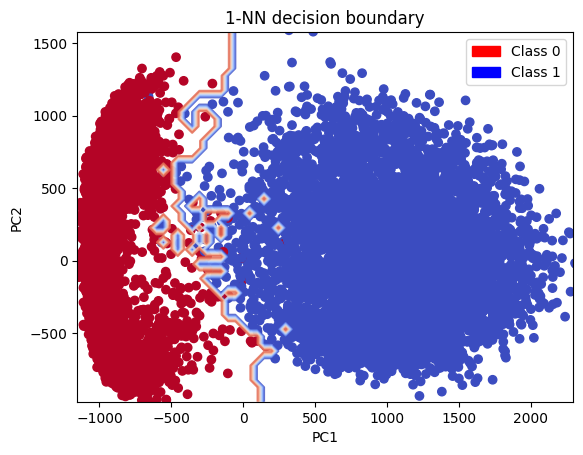

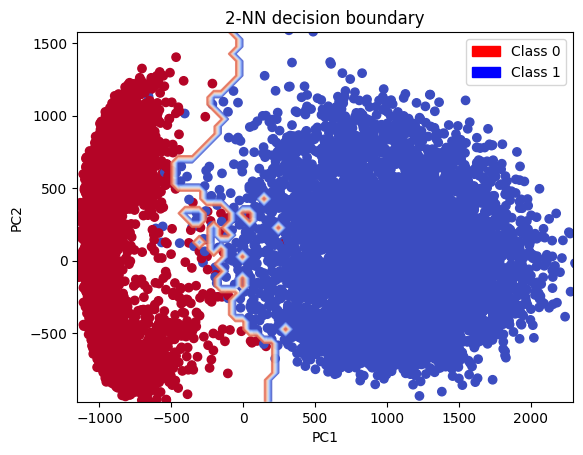

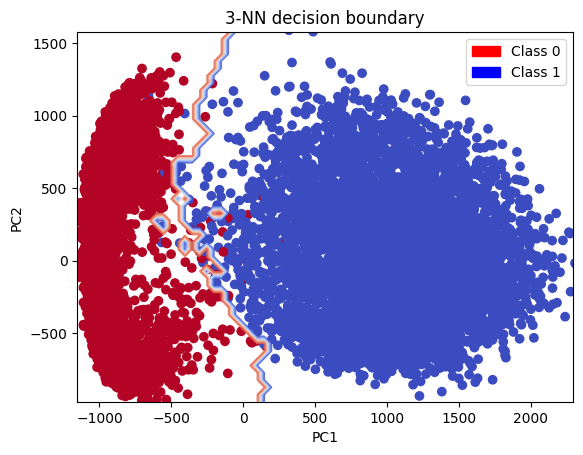

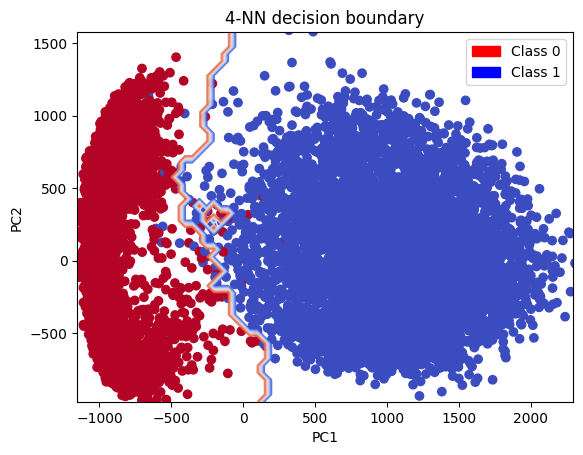

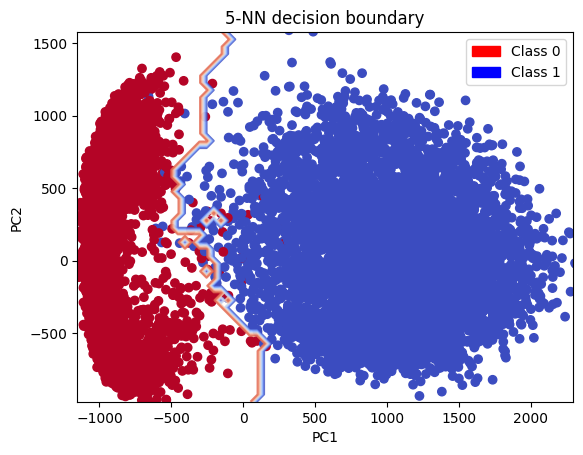

In [7]:
K_VALUES = [1, 2, 3, 4, 5]
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

X_PC, Y = prep_mnist(mnist_trainset, 2)
X_test_PC, Y_test = prep_mnist(mnist_testset, 2)

knn = KNNClassifier(X_PC, Y)
preds_results = {}
for k_val in K_VALUES:
    knn.plot_decision_boundary(k_val)
    preds_results[k_val] = []
    for i in range(len(X_test_PC)):
        pred = knn.classify(X_test_PC[i], k_val)
        preds_results[k_val].append((pred, Y_test[i]))


In [39]:
for k_val in preds_results:
    correct = 0
    for pred in preds_results[k_val]:
        if pred[0] == pred[1]:
            correct += 1
    print(f"KNN with k:{k_val} is {correct/len(preds_results[k_val])}")
    

KNN with k:1 is 0.9962174940898345
KNN with k:2 is 0.9947990543735225
KNN with k:3 is 0.9981087470449173
KNN with k:4 is 0.9971631205673759
KNN with k:5 is 0.9985815602836879


In [57]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
X_PC, Y = prep_mnist(mnist_trainset, 20)
X_test_PC, Y_test = prep_mnist(mnist_testset, 20)

# MED classifier
med_clf = MED_Classifier(X_PC, Y)

# preds_results = []
# for i in range(len(X_test_PC)):
#     pred = med_clf.classify(X_test_PC[i])
#     preds_results.append((pred, Y_test[i]))

# correct = 0
# for pred in preds_results:
#     if pred[0] == pred[1]:
#         correct += 1

X_PC_2D, Y = prep_mnist(mnist_trainset, 2)
med_clf_2D = MED_Classifier(X_PC_2D, Y)

In [56]:
med_clf.determine_decision_boundary_analytical()

(array([[ 1.92357514e+03,  3.23408877e+01, -3.44516061e+01,
          6.46258321e+01, -2.36600160e+01, -1.53948292e+01,
          7.15544438e+01,  5.72000513e+01, -7.34020124e+00,
          3.55513135e+01,  1.01578300e+01,  6.07837164e+00,
          1.39065948e+01,  1.18260723e+01,  4.16971893e+00,
          1.24767482e+00, -6.42924894e+00, -5.16248115e+00,
          9.88546523e+00, -1.22236803e+01]]),
 array([[120210.46558703]]))

In [85]:
X_PC_2D, Y = prep_mnist(mnist_trainset, 2)
med_clf_2D = MED_Classifier(X_PC_2D, Y)
weights, bias = med_clf_2D.determine_decision_boundary_analytical()
w1 = weights[0][0]
w2 = weights[0][1]
bias = bias[0]
x = np.linspace(-1000, 100, 10)
y = bias/w2 - (w1/w2) * x

(1, 2)


In [88]:
X_PC_2D[:,0].min()

-1153.9034612718901

In [90]:
bias[0]

119671.23453452945

(-1000.0, 2000.0)

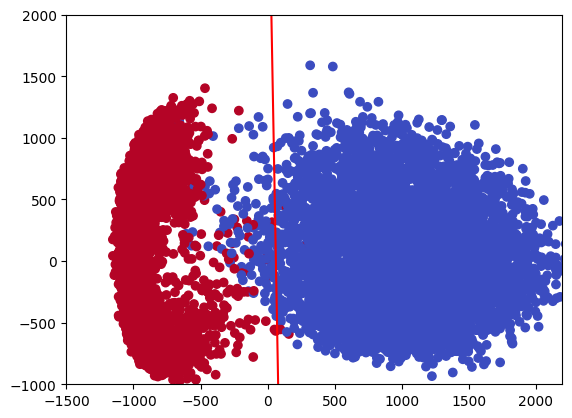

In [86]:
plt.plot(x,y, 'r')
plt.scatter(X_PC_2D[:, 0], X_PC_2D[:, 1], c=Y, cmap=plt.cm.coolwarm)
ax = plt.gca()
xlim = np.max(self.X_clf[:, 0])

xmin = 
xmax = 2200
ymin = -1000
ymax = 2000
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

In [41]:
prototype0, prototype1 = med_clf.output_prototypes()

In [43]:
prototype0.shape[0]

20

In [44]:
prototype0 = prototype0.reshape(20,1)
prototype1 = prototype1.reshape(20,1)

In [51]:
(prototype0-prototype1).T

array([[ 1.92357514e+03,  3.23408877e+01, -3.44516060e+01,
         6.46258321e+01, -2.36600161e+01, -1.53948291e+01,
         7.15544188e+01,  5.72000751e+01, -7.34000839e+00,
         3.55514445e+01,  1.01577129e+01,  6.07755762e+00,
         1.39060865e+01,  1.18253133e+01,  4.16982429e+00,
         1.24503672e+00, -6.41338239e+00, -5.17052524e+00,
         9.86208920e+00, -1.21618156e+01]])

In [81]:
weights.sh

array([[1923.575144  ,   32.34088132]])

In [46]:
1/2* (np.matmul(prototype0.T, prototype0) - np.matmul(prototype1.T, prototype1))

array([[120210.3965457]])

In [52]:
0.5 * (np.transpose(prototype0) * prototype0 - np.transpose(prototype1) * prototype1)

array([[ 1.19637416e+05,  2.01145261e+03, -2.14272946e+03,
         4.01942581e+03, -1.47154282e+03, -9.57486676e+02,
         4.45035163e+03,  3.55757830e+03, -4.56514341e+02,
         2.21113429e+03,  6.31762440e+02,  3.77995782e+02,
         8.64893819e+02,  7.35479417e+02,  2.59343653e+02,
         7.74354863e+01, -3.98882519e+02, -3.21582592e+02,
         6.13376022e+02, -7.56408297e+02],
       [ 2.01145261e+03,  3.38183632e+01, -3.60255086e+01,
         6.75782275e+01, -2.47409108e+01, -1.60981333e+01,
         7.48233428e+01,  5.98132288e+01, -7.67533261e+00,
         3.71755925e+01,  1.06217624e+01,  6.35520748e+00,
         1.45413783e+01,  1.23655462e+01,  4.36032040e+00,
         1.30191554e+00, -6.70637421e+00, -5.40673783e+00,
         1.03126333e+01, -1.27174214e+01],
       [-2.14272946e+03, -3.60255086e+01,  3.83767026e+01,
        -7.19887003e+01,  2.63556190e+01,  1.71487731e+01,
        -7.97066659e+01, -6.37169213e+01,  8.17626089e+00,
        -3.96018464e+01, -1.1

In [142]:
# GED CLF

In [143]:
X, Y = prep_mnist(mnist_trainset, 2)
X_test_PC, Y_test = prep_mnist(mnist_testset, 2)


In [144]:
covariance1

array([[ 22049.6871,  -8583.7733],
       [ -8583.7733, 380576.5985]])

In [145]:
eigvals0, eigvecs0 = np.linalg.eig(covariance0)

In [147]:
mean0 = np.mean([X[i] for i in range(len(X)) if Y[i] == 0], axis=0)
mean1 = np.mean([X[i] for i in range(len(X)) if Y[i] == 1], axis=0)

In [148]:
covariance0 = np.cov([X[i] for i in range(len(X)) if Y[i] == 0], rowvar=False)
covariance1 = np.cov([X[i] for i in range(len(X)) if Y[i] == 1], rowvar=False)
covariance0_inverse = np.linalg.inv(covariance0)
covariance1_inverse = np.linalg.inv(covariance1)

In [149]:
eigvals1, eigvecs1 = np.linalg.eig(covariance1)
weight_matrix1 = np.diag(eigvals1 ** (-1/2)) @ eigvecs1.T
covariance1_inverse = weight_matrix1.T @ weight_matrix1

In [150]:
eigvals0, eigvecs0 = np.linalg.eig(covariance0)
weight_matrix0 = np.diag(eigvals0 ** (-1/2)) @ eigvecs0.T
covariance0_inverse_eig = weight_matrix0.T @ weight_matrix0

In [159]:
eigvals0, eigvecs0 = np.linalg.eig(covariance0)

In [167]:
np.set_printoptions(precision=10)
np.set_printoptions(threshold=np.inf)

In [179]:
np.diag(eigvals0 ** (-1/2)) @ eigvecs0.T

array([[ 0.0017895306, -0.0010761661],
       [ 0.0012268473,  0.0020400947]])

In [234]:
print_latex_matrix(np.diag(eigvals1 ** (-1/2)), p=5)

'0.006766 & 0.0\\0.0 & 0.0016205\\'

In [238]:
print_latex_matrix(covariance1_inverse, p=5)

'4.5754e-05 & 1.032e-06\\1.032e-06 & 2.6509e-06\\'

In [227]:
eigvecs1

array([[-0.9997138464,  0.0239212327],
       [-0.0239212327, -0.9997138464]])

In [216]:
eigvals1

array([ 21844.293832134, 380782.014364141])

In [243]:
signif(mean1[1], 5)

-15.125

In [173]:
foo = np.array([[1, 2], [3, 4]])

In [175]:
foo.T

array([[1, 3],
       [2, 4]])

In [172]:
eigvecs0.T

array([[ 0.8569753561, -0.5153573897],
       [ 0.5153573897,  0.8569753561]])

In [154]:
covariance0

array([[215286.025 , -23351.2285],
       [-23351.2285, 190498.5081]])

In [59]:
eigvals, eigvecs = np.linalg.eig(covariance0)
eigvecs

array([[-1.72840029e-01,  3.89017042e-01, -6.98990579e-01,
         1.21049441e-01, -8.34592549e-02,  1.02473399e-01,
         5.34345324e-02, -2.23991103e-02,  2.85045356e-02,
         3.81122748e-01,  2.87568532e-01,  4.89507987e-02,
        -3.56774648e-02, -2.70918521e-02,  1.98286421e-01,
        -1.38760503e-01, -6.39687078e-03,  2.81015302e-03,
        -5.42335621e-02, -4.77067996e-04],
       [ 5.37320519e-01,  1.55746565e-01, -4.77439744e-03,
         1.27871927e-01, -1.20501998e-01,  7.83182046e-02,
        -1.73986646e-01, -3.10384133e-01,  3.78892016e-01,
        -2.39348627e-01,  4.92584684e-01, -1.49463628e-01,
         6.74363762e-02,  5.41426588e-02, -1.37586552e-01,
         1.54505542e-01,  3.81944229e-02,  3.21586103e-03,
         6.22890932e-02, -4.39924454e-02],
       [-8.16089148e-01, -4.65561916e-02,  1.70172170e-01,
         1.20136414e-03, -3.17596685e-02,  4.53214626e-02,
        -1.19733073e-01, -2.16193817e-01,  2.54241200e-01,
        -1.73008105e-01,  3.2

In [43]:
np.diag(eigvals0 ** (-1/2))

array([[0.00208819, 0.        ],
       [0.        , 0.00238058]])

In [195]:
print(covariance0_inverse_eig)

[[4.7075739556e-06 5.7705247246e-07]
 [5.7705247246e-07 5.3201197954e-06]]


In [18]:
s1 = np.array([[3, -2], [-2, 1]])

In [22]:
np.linalg.inv(s1)

array([[-1., -2.],
       [-2., -3.]])

In [27]:
x = X_test_PC[0]
y = Y_test[0]

In [39]:
dist0 = np.sqrt(((x - mean0).T @ covariance0_inverse @ (x - mean0)))
dist1 = np.sqrt(((x - mean1).T @ covariance1_inverse @ (x - mean1)))

Accuracy for 2D GED Classifier: 99.669%


C:\ProgramData\Miniconda3\envs\ml37\lib\site-packages\ipykernel_launcher.py:208: UserWarning: The following kwargs were not used by contour: 'level'


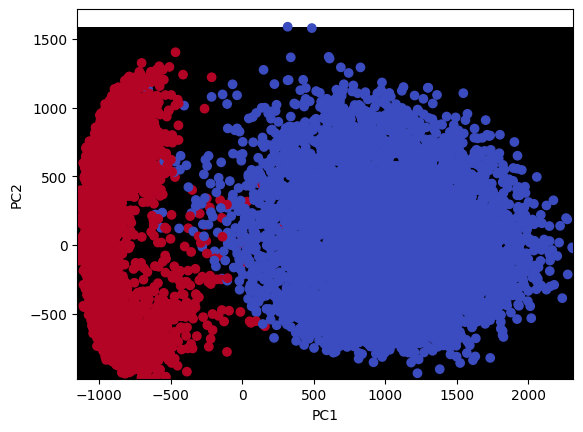

In [67]:
def decision_boundary_fct(x1, x2):
    x = np.array([x1, x2])
    return np.sqrt(((x - mean0).T @ covariance0_inverse @ (x - mean0))) - np.sqrt(((x - mean1).T @ covariance1_inverse @ (x - mean1)))

In [291]:
X_PC, Y = prep_mnist(mnist_trainset, 2)
X_test_PC, Y_test = prep_mnist(mnist_testset, 2)
preds_results = []
ged_clf = GED_Classifier(X_PC, Y)
Q0, Q1, Q2 = ged_clf.determine_decision_boundary_analytical()
#1&2&3\\4&5&6\\7&8&9\\

In [292]:
ged_clf.print_decision_boundary_analytical()

Decision boundary equation: -4.105e-05x1x1 + -4.5e-07x1x2 + -4.5e-07x2x1 + 2.67e-06x2x2 + -0.09201166x1 + -0.00330184x2 + -32.09772685 = 0


In [286]:
Q2

-32.0977269960862

In [115]:
equation = ""
Q0_round = np.zeros(Q0.shape)
for i in range(20):
    for j in range(20):
        Q0_round[i][j] = signif(Q0[i][j], 3)

In [223]:
def print_latex_matrix(matrix, p=7):
    equation = r""
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if j == (matrix.shape[1] - 1):
                equation += f"{signif(matrix[i][j], p)}"
            else:
                equation += f"{signif(matrix[i][j], p)} & "
        equation += "\\"
    return equation

In [193]:
print_latex_matrix(eigvecs0)

1
1


'0.857 & 0.515\\-0.515 & 0.857\\'

In [130]:
Q0_round[0][0]

-0.000266

In [111]:
def signif(x, p=7):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

In [112]:
signif(Q0[0][0], 3)

-0.000266

In [118]:
foo = Math(data=[Matrix(np.round(Q0_round, 8))])
hello = foo.dumps()

In [123]:
hello.replace("\n", "").replace("%", "")

'\\[\\begin{pmatrix}-0.000266&-6.99e-06&-1.53e-05&0.000101&-4.5e-05&8.84e-05&1.76e-05&8.28e-05&5.97e-05&0.000269&5.65e-05&8.23e-05&0.000155&-7.57e-05&4.85e-05&-4.87e-05&0.000104&4.33e-05&-8.66e-06&4.49e-05\\\\-6.99e-06&-0.000101&0.000334&-0.000162&8.96e-05&0.000104&-4.97e-05&0.000115&3.38e-05&0.000193&-5.27e-05&6.58e-05&2.32e-05&-0.000146&-2.33e-05&3.47e-06&-9.62e-06&-5.7e-05&5.01e-06&2.26e-05\\\\-1.53e-05&0.000334&-0.000552&0.000432&-0.000167&-0.000259&9.89e-05&-0.000241&-8.71e-05&-0.000314&7.05e-05&-0.000134&-6.6e-05&0.000262&1.78e-05&-2.58e-05&6.56e-05&9.36e-05&-4.44e-05&-4.88e-06\\\\0.000101&-0.000162&0.000432&-0.000958&7.02e-06&0.000196&-0.000128&8.17e-05&6.05e-05&0.000426&-4.5e-05&0.000109&0.000183&-6.73e-05&-2.04e-05&5.46e-05&-0.000125&-0.000142&5.79e-05&-0.000122\\\\-4.5e-05&8.96e-05&-0.000167&7.02e-06&-7.35e-05&-0.000186&-3.94e-05&-8.51e-05&4.9e-06&-2.71e-05&-2.56e-05&-1.82e-05&8.46e-05&9.11e-05&-1.93e-06&3.03e-05&3.07e-06&-2.43e-05&4.5e-06&-2.14e-05\\\\8.84e-05&0.000104&-0.00